# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

## Neural Network Model

Prompt:

```md
give me a tensorflow scaffolding that:
loads test, train, validate csvs from ./data
takes 7 features in a timeseries, with seasonality, across 12 months for 14 years
outputs a signal for an entire year
```

In [27]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

# Constants here
START_DATE = datetime(2008, 1, 1)
END_DATE = datetime(2022, 12, 31)
DATA_PATH = "./data"

train_df = pd.read_csv(f"{DATA_PATH}/train_data.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv(f"{DATA_PATH}/test_data.csv", index_col=0, parse_dates=True)
validate_df = pd.read_csv(
    f"{DATA_PATH}/validate_data.csv", index_col=0, parse_dates=True
)

train_df.head(5)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,powerplants_c02_kt,GDP_bln,Population_k,tmin,tavg,tmax
Date,,,,,,,,,,
2008-01-01,0.36,191.50,0.0,0.0,170.39,6.210000,409.379000,12.1,14.5,16.9
2008-02-01,0.37,183.60,0.0,0.0,163.36,6.214167,409.379000,10.5,13.3,16.1
2008-03-01,0.34,178.96,0.0,0.0,159.23,6.218333,409.637167,12.1,14.9,17.7
2008-04-01,0.32,172.61,0.0,0.0,153.58,6.222500,409.895333,13.9,17.4,20.9
2008-05-01,0.32,179.50,0.0,0.0,159.71,6.226667,410.153500,16.8,20.2,23.7


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

FEATURES = [
    "powerplants_c02_kt",
    "Population_k",
    "tmax",
    "GDP_bln",
]
TARGET = "Plant_Production_GWh"

X_train = train_df[FEATURES]
y_train = train_df[TARGET]
y_test = test_df[TARGET]
X_test = test_df[FEATURES]
y_validate = validate_df[TARGET]
X_validate = validate_df[FEATURES]

X_train = np.array(X_train)
X_test = np.array(X_test)
X_validate = np.array(X_validate)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_validate = np.array(y_validate)


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_validate = X_validate.reshape((X_validate.shape[0], 1, X_validate.shape[1]))

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_validate, y_validate),
    verbose=0,
)

loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
model.summary()

1/1 [==============================] - 0s 31ms/step - loss: 46508.9648
Test Loss: 46508.96484375
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                11000     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 31ms/step


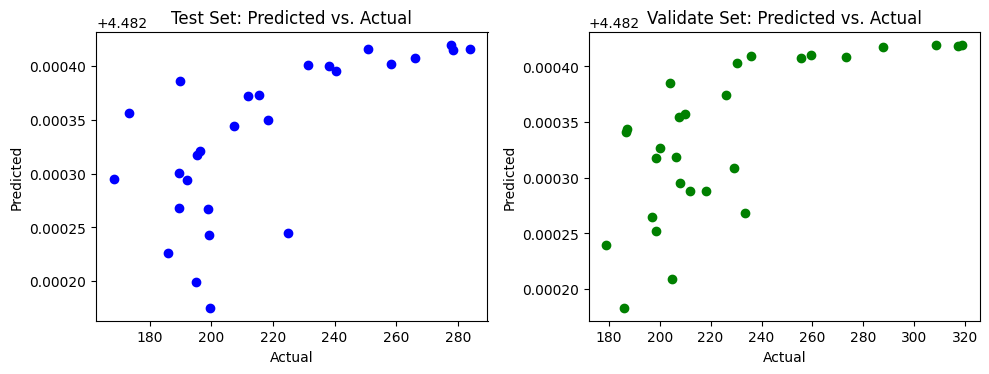

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
test_predictions = model.predict(X_test)
plt.scatter(y_test, test_predictions, color="blue")
plt.title("Test Set: Predicted vs. Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(1, 2, 2)
validate_predictions = model.predict(X_validate)
plt.scatter(y_validate, validate_predictions, color="green")
plt.title("Validate Set: Predicted vs. Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# absolute mess!!!! include lag, ma, and all that
plt.tight_layout()
plt.show()

Givens:
- This is a multivariate TS of pop, temp, demand, industry signals.
- Assume these are asynchronous, therefore noisy

Data DIM:
- 0: Sequences
- 1: Data in sequence
- 2: Features for that datum (AKA channels for COV1D)

In [30]:
STEPS = 12


def encode_ts(df):
    sequences = []
    labels = []
    for i in range(len(df) - STEPS):
        sequence = df[FEATURES].iloc[i : i + STEPS].values.flatten()
        label = df[TARGET].iloc[
            i + STEPS
        ]  # Assuming 'Max_Demand_GW' is the target variable

        sequences.append(sequence)
        labels.append(label)
    X = np.array(sequences)
    y = np.array(labels)

    return X, y


X, y = encode_ts(train_df)

print(f"Shapes: {X.shape} & {y.shape}")

Shapes: (113, 48) & (113,)


In [31]:
from tensorflow.keras.layers import Conv1D, Flatten, Input, MaxPooling1D, Dropout

BATCH_SIZE = 32
FILTER = 8
DROPRATE = 0.01

model = Sequential(
    [
        Input(shape=(STEPS, len(FEATURES))),
        Conv1D(FILTER, kernel_size=1, activation="relu"),
        Conv1D(FILTER, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Conv1D(FILTER, kernel_size=3, activation="relu"),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dropout(DROPRATE),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(optimizer="adam", loss="mse")
model.fit(
    X.reshape(X.shape[0], STEPS, len(FEATURES)),
    y,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=0,
)

X_test, y_test = encode_ts(test_df)
X_test_reshaped = X_test.reshape(X_test.shape[0], STEPS, len(FEATURES))
loss = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {loss}")
model.summary()

1/1 [==============================] - 0s 167ms/step - loss: 49570.6055
Test Loss: 49570.60546875
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 12, 8)             40        
                                                                 
 conv1d_19 (Conv1D)          (None, 10, 8)             200       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 5, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 3, 8)              200       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1, 8)             0         
 g1D)                                                            
                     

1/1 [==============================] - 0s 35ms/step


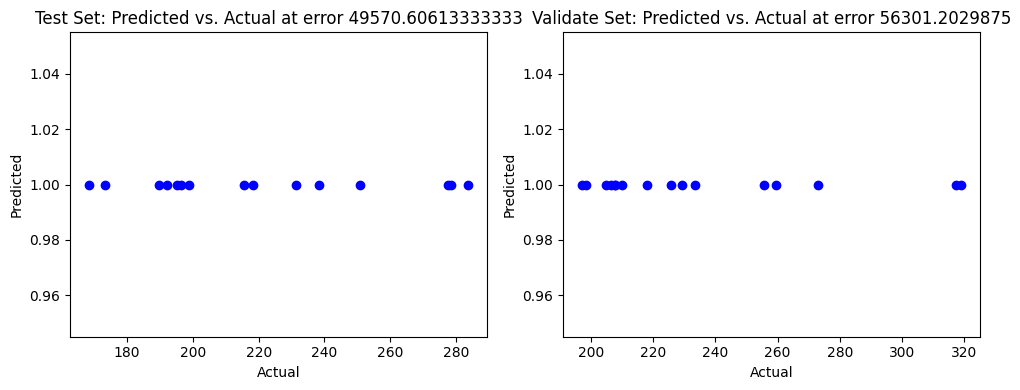

In [32]:
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)


y_pred = model.predict(X_test_reshaped)

plt.scatter(y_test, y_pred, color="blue")
mse = mean_squared_error(y_test, y_pred)

plt.title(f"Test Set: Predicted vs. Actual at error {mse}")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(1, 2, 2)

X_val, y_val = encode_ts(validate_df)
X_val_reshaped = X_val.reshape(X_val.shape[0], STEPS, len(FEATURES))
y_pred = model.predict(X_val_reshaped)

plt.scatter(y_val, y_pred, color="blue")
mse = mean_squared_error(y_val, y_pred)

plt.title(f"Validate Set: Predicted vs. Actual at error {mse}")

plt.xlabel("Actual")
plt.ylabel("Predicted")

# absolute mess!!!! include lag, ma, and all that
plt.tight_layout()
plt.show()